<a href="https://colab.research.google.com/github/Noah-To/AML/blob/main/AML_assignment_task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive and import libraries
from google.colab import drive
drive.mount('/content/drive')

# import necessary libraries
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Load dataset from Google Drive
folder_path = "/content/drive/MyDrive/AMLfiles/spamDetection"
training_data_file = pd.read_csv(f"{folder_path}/spam_detection_training_data.csv")
testing_data_file = pd.read_csv(f"{folder_path}/spam_detection_test_data.csv")
print("Train data:", training_data_file.shape)
print("Test data:", testing_data_file.shape)


Train data: (3619, 2)
Test data: (1552, 1)


In [3]:
# Preprocess text (lowercase, remove punctuation, stopwords)
STOPWORDS = {
    'the', 'and', 'is', 'in', 'to', 'with', 'a', 'for', 'of', 'on',
    'this', 'that', 'it', 'at', 'as', 'by', 'from', 'are', 'an', 'be',
    'or', 'if', 'but', 'not', 'have', 'has', 'you', 'i', 'we', 'our',
    'can', 'will', 'your', 'was', 'he', 'she', 'they', 'them', 'do'
}

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    filtered = [word for word in words if word not in STOPWORDS]
    return ' '.join(filtered)

training_data_file['text_clean'] = training_data_file['text'].apply(preprocess_text)
testing_data_file['text_clean'] = testing_data_file['text'].apply(preprocess_text)


In [4]:
# Vectorize using TF-IDF
X_train_text, X_value_text, y_train, y_value = train_test_split(
    training_data_file['text_clean'], training_data_file['label'], test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=3000)
X_train_vec = vectorizer.fit_transform(X_train_text)
X_val_vec = vectorizer.transform(X_value_text)
X_test_vec = vectorizer.transform(testing_data_file['text_clean'])


In [5]:
# Train and evaluate Naive Bayes model
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train_vec, y_train)
naive_bayes_predicts = naive_bayes_model.predict(X_val_vec)
print(" Naive Bayes Results: ")
print(classification_report(y_value, naive_bayes_predicts))
print("Confusion Matrix: ")
print(confusion_matrix(y_value, naive_bayes_predicts))


 Naive Bayes Results: 
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       509
           1       0.89      0.96      0.92       215

    accuracy                           0.95       724
   macro avg       0.93      0.95      0.94       724
weighted avg       0.95      0.95      0.95       724

Confusion Matrix: 
[[483  26]
 [  9 206]]


In [6]:
#Train and evaluate Logistic Regression model
logistic_regression_model = LogisticRegression(max_iter=1000)
logistic_regression_model.fit(X_train_vec, y_train)
logistic_regression_predicts = logistic_regression_model.predict(X_val_vec)
print(" Logistic Regression Results: ")
print(classification_report(y_value, logistic_regression_predicts))
print("Confusion Matrix: ")
print(confusion_matrix(y_value, logistic_regression_predicts))



 Logistic Regression Results: 
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       509
           1       0.96      0.97      0.97       215

    accuracy                           0.98       724
   macro avg       0.97      0.98      0.98       724
weighted avg       0.98      0.98      0.98       724

Confusion Matrix: 
[[500   9]
 [  6 209]]


In [7]:
# Save predictions to CSV
naive_bayes_test_predicts = naive_bayes_model.predict(X_test_vec)
logistic_regression_test_predicts = logistic_regression_model.predict(X_test_vec)
np.savetxt(f"{folder_path}/naive_bayes_predictions.csv", naive_bayes_test_predicts, delimiter=',', fmt='%d')
np.savetxt(f"{folder_path}/logistic_regression_predictions.csv", logistic_regression_test_predicts, delimiter=',', fmt='%d')


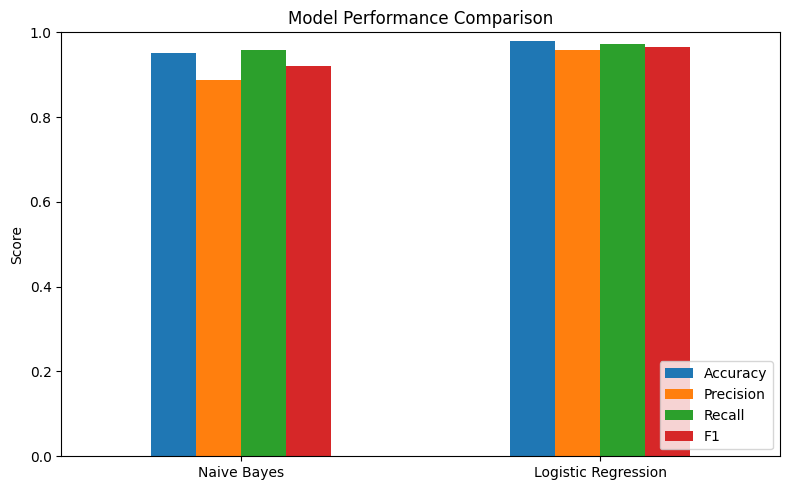

In [8]:
# Bar chart of model metrics
metrics = {
    "Naive Bayes": {
        "Accuracy": accuracy_score(y_value, naive_bayes_predicts),
        "Precision": precision_score(y_value, naive_bayes_predicts),
        "Recall": recall_score(y_value, naive_bayes_predicts),
        "F1": f1_score(y_value, naive_bayes_predicts)
    },
    "Logistic Regression": {
        "Accuracy": accuracy_score(y_value, logistic_regression_predicts),
        "Precision": precision_score(y_value, logistic_regression_predicts),
        "Recall": recall_score(y_value, logistic_regression_predicts),
        "F1": f1_score(y_value, logistic_regression_predicts)
    }
}
metrics_df = pd.DataFrame(metrics).T
plt.figure(figsize=(8, 5))
metrics_df.plot(kind='bar', ax=plt.gca())
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


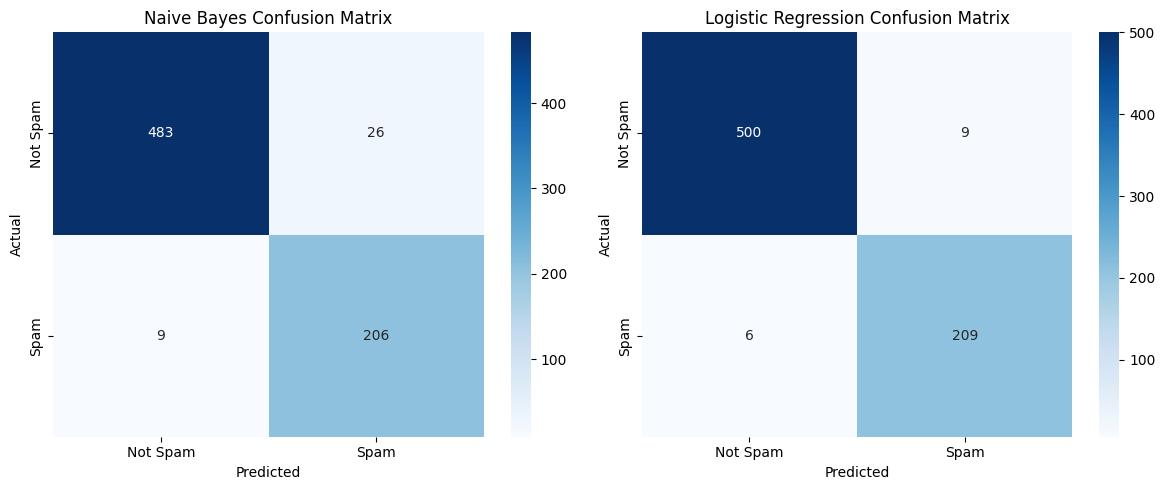

In [9]:
# Confusion matrix heatmaps
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
cm_naive_bayes = confusion_matrix(y_value, naive_bayes_predicts)
sns.heatmap(cm_naive_bayes, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
cm_logistic_regression = confusion_matrix(y_value, logistic_regression_predicts)
sns.heatmap(cm_logistic_regression, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

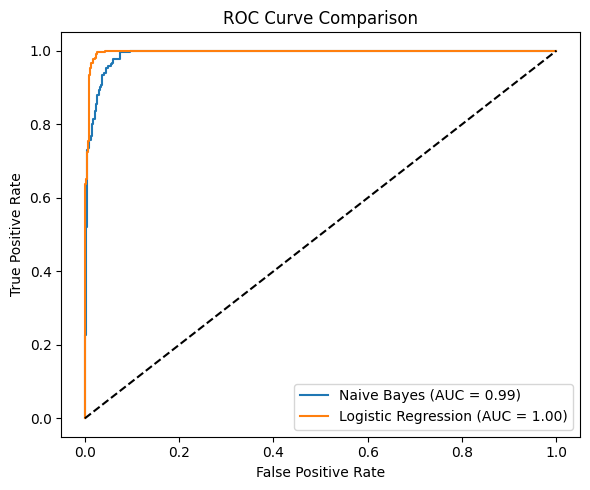

In [10]:
# ROC Curve comparison
plt.figure(figsize=(6, 5))
naive_bayes_probs = naive_bayes_model.predict_proba(X_val_vec)[:, 1]
fpr_naive_bayes, tpr_naive_bayes, _ = roc_curve(y_value, naive_bayes_probs)
auc_naive_bayes = auc(fpr_naive_bayes, tpr_naive_bayes)
plt.plot(fpr_naive_bayes, tpr_naive_bayes, label=f'Naive Bayes (AUC = {auc_naive_bayes:.2f})')

logistic_regression_probs = logistic_regression_model.predict_proba(X_val_vec)[:, 1]
fpr_logistic_regression, tpr_logistic_regression, _ = roc_curve(y_value, logistic_regression_probs)
auc_logistic_regression = auc(fpr_logistic_regression, tpr_logistic_regression)
plt.plot(fpr_logistic_regression, tpr_logistic_regression, label=f'Logistic Regression (AUC = {auc_logistic_regression:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [13]:
# Convert validation labels and texts to aligned Series
value_texts = X_value_text.reset_index(drop=True)
true_labels = y_value.reset_index(drop=True)
pred_nb = pd.Series(naive_bayes_predicts)
pred_lr = pd.Series(logistic_regression_predicts)


In [14]:
# False positives: ham predicted as spam
print("Logistic Regression - False Positives:")
print(value_texts[(true_labels == 0) & (pred_lr == 1)].head())

# False negatives: spam predicted as ham
print("\nLogistic Regression - False Negatives:")
print(value_texts[(true_labels == 1) & (pred_lr == 0)].head())


Logistic Regression - False Positives:
23     subject holiday party save date please click l...
34     subject dear all wish find out more about miss...
126    subject digitize memories compaq scanners tire...
154    subject president juno com exciting news free ...
157    subject income tax daren tell tonya called edi...
Name: text_clean, dtype: object

Logistic Regression - False Negatives:
70     subject bkst pknns enlargkmknt pnlls clck hr b...
156    subject his lips his nose good day tried call ...
163    subject norwich supervitagra ciaxlis take once...
221    subject re know what wish goodbye gargle copol...
393    subject talked rosella about plan here s lube ...
Name: text_clean, dtype: object
